# Computer Vision Course Project

## Park Vision


### Setup

In [4]:
%pip install --quiet ultralytics scikit-learn opencv-python tqdm matplotlib pandas kagglehub

Note: you may need to restart the kernel to use updated packages.


In [5]:
import kagglehub
import torch

from ultralytics import YOLO #Handles YOLO class from YOLOV8 Library
from ultralytics.utils.plotting import Annotator #Annotator for bounding boxes and image labels

import cv2 #OpenCV

import os #Operating system (directories/files)
import shutil #High level file operations (ex. copy/delete directories)
import random #Used for randomly splitting or augmenting dataset
import xml.etree.ElementTree as ET #Parse/Manipulate XML files
from sklearn.model_selection import train_test_split #Used to split dataset into training validation and test sets
from tqdm import tqdm #Used to add progress bar to loops

import matplotlib.pyplot as plt #Image, chart plotter
import pandas as pd #Data analysis library

In [7]:
# Check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [ ]:
# # Download latest version
# path = kagglehub.dataset_download("blanderbuss/parking-lot-dataset")

# print("Path to dataset files:", path)

### Test YOLO and annotations are functioning correctly

YOLOv8n summary: 129 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs

image 1/1 /Users/aaron/Library/CloudStorage/OneDrive-Personal/University/Current Semester/Computer Vision - 4220/courseProject/ParkVision/06-object-detection-using-yolo/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 44.1ms
Speed: 4.5ms preprocess, 44.1ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 480)


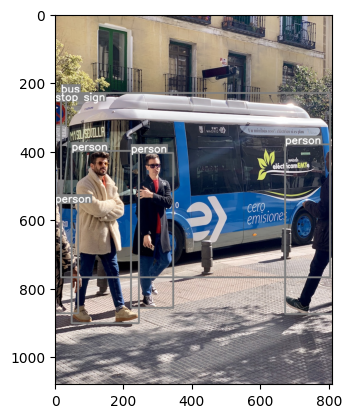

In [8]:
model = YOLO('06-object-detection-using-yolo/yolov8n.pt')
model.info()
results = model('06-object-detection-using-yolo/bus.jpg')


annotator = Annotator(cv2.cvtColor(results[0].orig_img, cv2.COLOR_BGR2RGB))
boxes = results[0].boxes
for box in boxes:
    b = box.xyxy[0]  # get box coordinates in (left, top, right, bottom) format
    c = box.cls
    annotator.box_label(b, model.names[int(c)])

plt.imshow(annotator.result())

### Transform the dataset to be YOLO ready

In [ ]:
#----------------------------------------
# Define class map
#----------------------------------------

class_name_to_id_mapping = {
    "vacant": 0,
    "occupied": 1
}

#----------------------------------------
# Determine Paths
#----------------------------------------

#Original Dataset Location
root_dir = "PKLot"

#New Yolo Ready Dataset
outputDir = "PKLot_YOLORdy"
imagesOutput = os.path.join(outputDir, "images")
labelsOutput = os.path.join(outputDir, "labels")

for sub in ['train', 'val', 'test']:
    os.makedirs(os.path.join(imagesOutput, sub), exist_ok=True) #Path to store images
    os.makedirs(os.path.join(labelsOutput, sub), exist_ok=True) #Path to store YOLO labels


#----------------------------------------
# Parse XML annoatation files
#----------------------------------------

def extract_info_from_xml(xml_path): #Function to extract bounding boxes from XML files
    tree = ET.parse(xml_path)
    root = tree.getroot()

    filename = os.path.splitext(os.path.basename(xml_path))[0] + ".jpg" #Get corresponding image filename
    bboxes = [] #List of bounding boxes for this image

    for space in root.findall("space"): #Loop through each sapce tag in XML (which is a spot)
        
        #Get the occupancy state from XML annoatation
        occupied = space.attrib.get("occupied", "0")
        class_label = "occupied" if occupied == "1" else "vacant"
        class_id = class_name_to_id_mapping[class_label]

        #Read contour and extrac xy
        points = space.find("contour").findall("point")
        x_coords = [int(pt.attrib['x']) for pt in points]
        y_coords = [int(pt.attrib['y']) for pt in points]

        # Convery poly to bounding box
        xmin, xmax = min(x_coords), max(x_coords)
        ymin, ymax = min(y_coords), max(y_coords)

        #append bound box with class ID
        bboxes.append((class_id, xmin, ymin, xmax, ymax))

    return filename, bboxes

#----------------------------------------
# Convert bounding boxes to YOLO format and save as .txt
#----------------------------------------
def convert_to_yolo(filename, bboxes, img_width, img_height, save_path):
    
    lines = []

    for class_id, xmin, ymin, xmax, ymax in bboxes:
        
        #Convert to YOLO format: normalized center_x, center_y, width, height
        x_center = ((xmin + xmax) / 2) / img_width
        y_center = ((ymin + ymax) / 2) / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height
        lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}") #append the completed line

    #write all lines to file
    with open(save_path, "w") as f:
        f.write("\n".join(lines))

# -------------------------------
# Collect image + annotation file pairs
# -------------------------------
image_label_pairs = [] #List to store matched image/XML paths

print("Collecting the files ... ")

#Loop through parking lot dirs
for lot in os.listdir(root_dir):
    lot_path = os.path.join(root_dir, lot)
    if not os.path.isdir(lot_path):
        continue  # skip if not a directory

    # loop through weather conditions (cloudy, rainy, sunny)
    for weather in os.listdir(lot_path): 
        weather_path = os.path.join(lot_path, weather)
        if not os.path.isdir(weather_path):
            continue  # skip if not dir

        #Loop through date folders
        for date_folder in os.listdir(weather_path):
            date_path = os.path.join(weather_path, date_folder)
            if not os.path.isdir(date_path):
                continue #skip non dirs 

            #loop through XML files, and also get matching jpg file
            for file in os.listdir(date_path):
                if file.endswith(".xml"):
                    xml_path = os.path.join(date_path, file)
                    jpg_path = xml_path.replace(".xml", ".jpg")
                    if os.path.exists(jpg_path):
                        image_label_pairs.append((jpg_path, xml_path)) #add to pairs list

#output how many pairs found
print(f"Found {len(image_label_pairs)} annotation image pairs.")

# -------------------------------
# Split into train, val, test
# -------------------------------

train_pairs, test_pairs = train_test_split(image_label_pairs, test_size=0.2, random_state=42)
val_pairs, test_pairs = train_test_split(test_pairs, test_size=0.5, random_state=42)

splits = [("train", train_pairs), ("val", val_pairs), ("test", test_pairs)]

# -------------------------------
# Process and write images + labels
# -------------------------------
print("Process and writing YOLO ready files")

for split_name, pairs in splits:
    for img_path, xml_path in tqdm(pairs, desc=f"Processing {split_name}"):
        try:
            #extract bounding from XML
            filename, bboxes = extract_info_from_xml(xml_path)
            if len(bboxes) == 0:
                continue #skip images with no bounding boxes

            #read image to get width/height
            img = cv2.imread(img_path)
            if img is None:
                continue #skip and unreadble images

            h, w = img.shape[:2]
            label_filename = os.path.splitext(filename)[0] + ".txt"

            # copy image to output folder
            new_img_path = os.path.join(imagesOutput, split_name, filename)
            shutil.copy(img_path, new_img_path)

            # save YOLO label in folder
            new_label_path = os.path.join(labelsOutput, split_name, label_filename)
            convert_to_yolo(filename, bboxes, w, h, new_label_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")


# -------------------------------
# Output Completion!
# -------------------------------
print("Dataset formatting complete")

Found 1212 image-annotation pairs.
Processing and writing YOLO files...


Processing test: 100%|███████████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 162.65it/s]

Dataset formatting complete


### Test the YOLO ready dataset

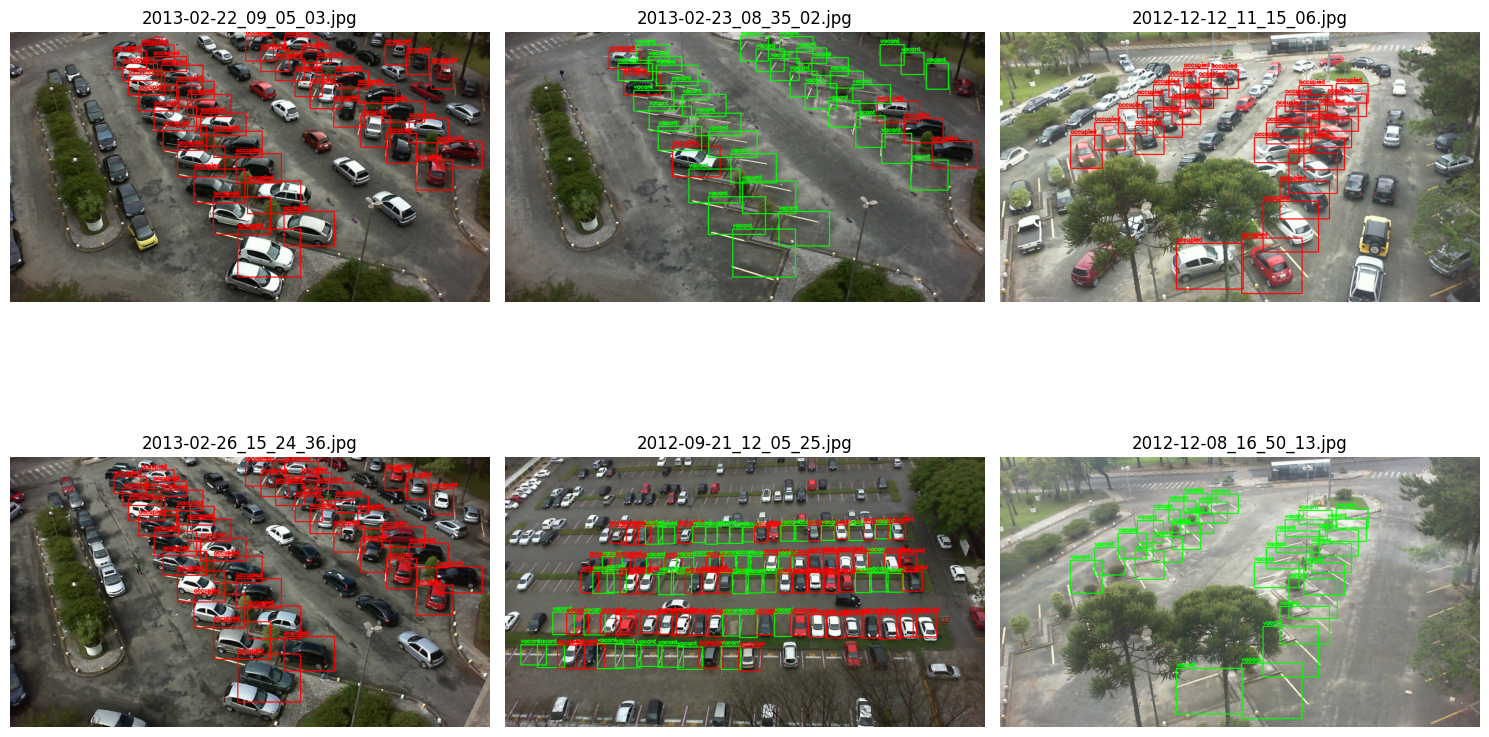

In [ ]:
# Set this to your dataset path
images_dir = "PKLot_YOLORdy/images/train"
labels_dir = "PKLot_YOLORdy/labels/train"

class_names = ['vacant', 'occupied']

#Get a set of 6 random images
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
sampled_images = random.sample(image_files, 6)

#draw the bounding boxes on the image
def draw_boxes(image_path, label_path):
    img = cv2.imread(image_path)
    h, w = img.shape[:2]
    
    with open(label_path, 'r') as f:
        for line in f:
            class_id, x_center, y_center, box_w, box_h = map(float, line.strip().split())
            x_center *= w
            y_center *= h
            box_w *= w
            box_h *= h

            x1 = int(x_center - box_w / 2)
            y1 = int(y_center - box_h / 2)
            x2 = int(x_center + box_w / 2)
            y2 = int(y_center + box_h / 2)

            class_id = int(class_id)
            color = (0, 255, 0) if class_id == 0 else (0, 0, 255)
            label = class_names[class_id]
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Plot the images with thier bound boxes
plt.figure(figsize=(15, 10))
for i, img_file in enumerate(sampled_images):
    img_path = os.path.join(images_dir, img_file)
    label_path = os.path.join(labels_dir, img_file.replace(".jpg", ".txt"))
    img_with_boxes = draw_boxes(img_path, label_path)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img_with_boxes)
    plt.title(img_file)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [19]:
print(os.path.exists('PKLot/PKLot.yaml'))  # Should return True

True


## Training 

*Real training done with google colab. Very simple training for basic test sake*

Using a pretrained yolo model with 5 epochs

In [21]:
model = YOLO('yolov8n.pt')  #Start w/ pretrained
results = model.train(data='PKLot/PKLot.yaml', epochs=5, device='mps')  #train for 5 epochs w/ customer yaml

New https://pypi.org/project/ultralytics/8.3.101 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.98 🚀 Python-3.11.6 torch-2.6.0 MPS (Apple M1 Pro)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=PKLot/PKLot.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=train14, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, sa

train: Scanning /Users/aaron/Library/CloudStorage/OneDrive-Personal/University/Current Semester/Computer Vision - 4220/courseProject/ParkVis

train: New cache created: /Users/aaron/Library/CloudStorage/OneDrive-Personal/University/Current Semester/Computer Vision - 4220/courseProject/ParkVision/PKLot_YOLORdy/labels/train.cache



val: Scanning /Users/aaron/Library/CloudStorage/OneDrive-Personal/University/Current Semester/Computer Vision - 4220/courseProject/ParkVisio

val: New cache created: /Users/aaron/Library/CloudStorage/OneDrive-Personal/University/Current Semester/Computer Vision - 4220/courseProject/ParkVision/PKLot_YOLORdy/labels/val.cache


Plotting labels to /Users/aaron/Library/CloudStorage/OneDrive-Personal/University/Current Semester/Computer Vision - 4220/Labs/yolov5/runs/detect/train14/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/aaron/Library/CloudStorage/OneDrive-Personal/University/Current Semester/Computer Vision - 4220/Labs/yolov5/runs/detect/train14
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      14.7G      1.967      2.288      1.214        889        640: 100%|██████████| 61/61 [06:10<00:00,  6.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:18<00:56, 18.71s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:26<00:24, 12.31s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:34<00:10, 10.39s/it]

WARNING ⚠️ NMS time limit 3.250s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:42<00:00, 10.67s/it]


                   all        121       6844      0.683      0.306      0.371      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      14.4G      1.432     0.9214     0.9999       1260        640: 100%|██████████| 61/61 [10:34<00:00, 10.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:06<00:20,  6.73s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:13<00:13,  6.81s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:20<00:06,  6.91s/it]

WARNING ⚠️ NMS time limit 3.250s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:28<00:00,  7.10s/it]

                   all        121       6844      0.825      0.247      0.323      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      15.4G       1.23     0.7344     0.9447        892        640: 100%|██████████| 61/61 [12:38<00:00, 12.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:09<00:29,  9.85s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:18<00:17,  8.99s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:26<00:08,  8.88s/it]

WARNING ⚠️ NMS time limit 3.250s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:41<00:00, 10.26s/it]


                   all        121       6844      0.889      0.184      0.264      0.184

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      14.3G      1.111     0.6625     0.9146        892        640: 100%|██████████| 61/61 [13:52<00:00, 13.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:10<00:32, 10.87s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:19<00:19,  9.78s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:27<00:08,  8.80s/it]

WARNING ⚠️ NMS time limit 3.250s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:38<00:00,  9.61s/it]


                   all        121       6844      0.953      0.205      0.285      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      14.5G       1.01      0.615     0.8928       1000        640: 100%|██████████| 61/61 [16:52<00:00, 16.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:07<00:23,  7.86s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:18<00:18,  9.29s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:26<00:08,  8.73s/it]

WARNING ⚠️ NMS time limit 3.250s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:35<00:00,  8.93s/it]


                   all        121       6844      0.971      0.172      0.245      0.191

5 epochs completed in 1.056 hours.
Optimizer stripped from /Users/aaron/Library/CloudStorage/OneDrive-Personal/University/Current Semester/Computer Vision - 4220/Labs/yolov5/runs/detect/train14/weights/last.pt, 6.2MB
Optimizer stripped from /Users/aaron/Library/CloudStorage/OneDrive-Personal/University/Current Semester/Computer Vision - 4220/Labs/yolov5/runs/detect/train14/weights/best.pt, 6.2MB

Validating /Users/aaron/Library/CloudStorage/OneDrive-Personal/University/Current Semester/Computer Vision - 4220/Labs/yolov5/runs/detect/train14/weights/best.pt...
Ultralytics 8.3.98 🚀 Python-3.11.6 torch-2.6.0 MPS (Apple M1 Pro)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:13<00:40, 13.54s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:21<00:20, 10.12s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  75%|███████▌  | 3/4 [00:35<00:12, 12.03s/it]

WARNING ⚠️ NMS time limit 3.250s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:45<00:00, 11.27s/it]


                   all        121       6844      0.839      0.204      0.286      0.193
                vacant        102       2927      0.734       0.24      0.294      0.201
              occupied        112       3917      0.943      0.168      0.277      0.186
Speed: 9.8ms preprocess, 65.9ms inference, 0.0ms loss, 120.7ms postprocess per image
Results saved to /Users/aaron/Library/CloudStorage/OneDrive-Personal/University/Current Semester/Computer Vision - 4220/Labs/yolov5/runs/detect/train14


### Testing trained model

Evaluating test set of images: 100%|██████████████████████████████████████████████████████████████████████| 122/122 [00:06<00:00, 19.00it/s]


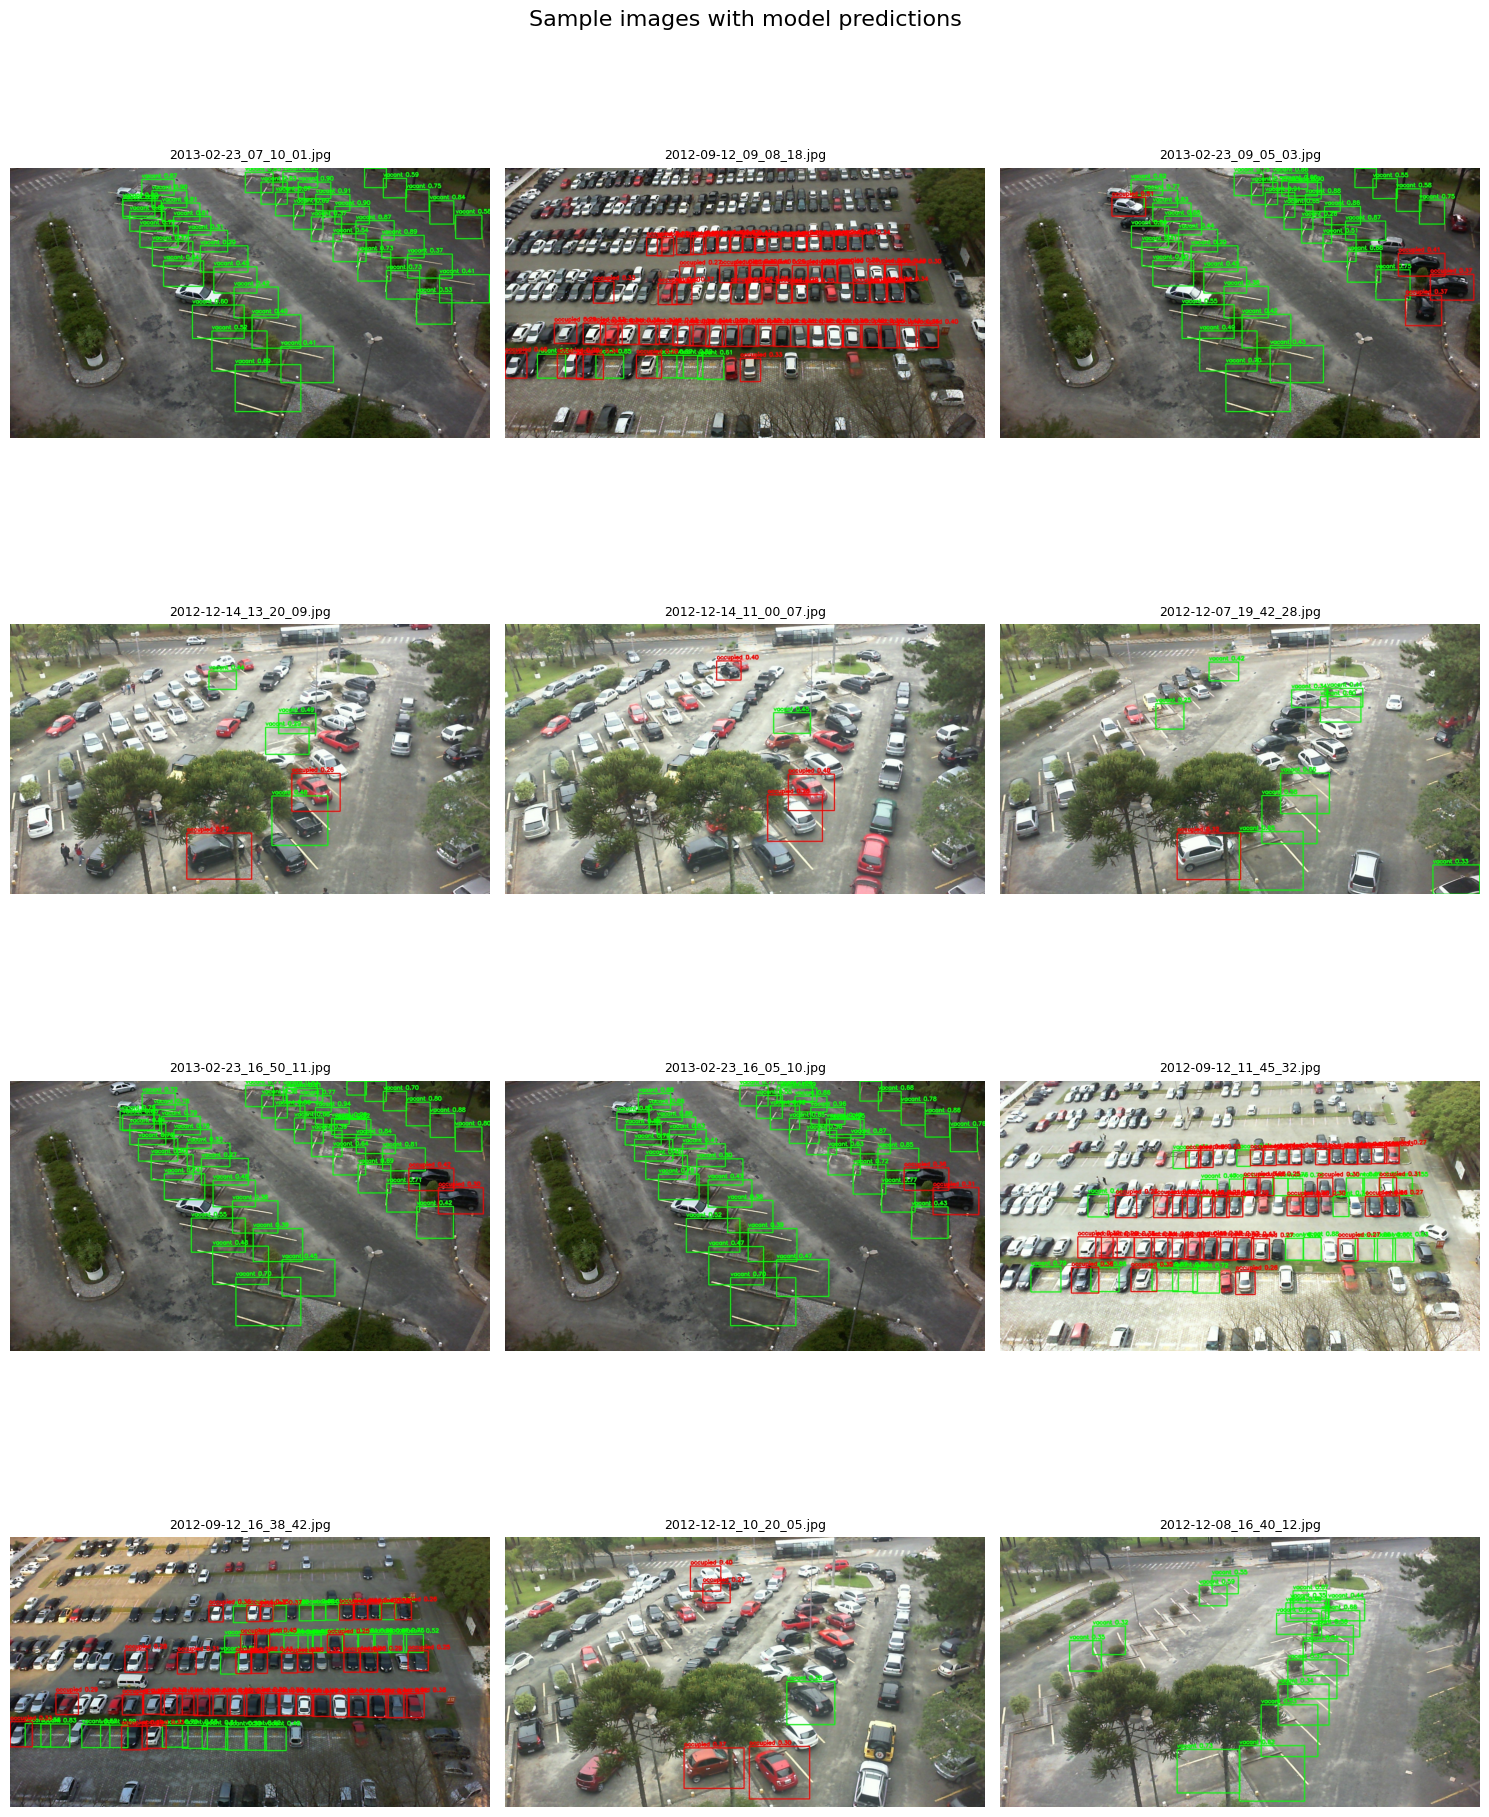


Summary Metrics Across All Images:

True Positives: 3990 out of 6200 ground truth spots
Detection Rate: 64.35%
Total False Positives (FP): 253
Total False Negatives (FN): 2210

Overall Precision: 0.940
Overall Recall: 0.644
Overall F1 Score: 0.764

Average Precision across images: 0.915
Average Recall across images:    0.587
Average F1 Score across images:  0.678

Annotated images saved to 'ModelResults/Result'
Detailed log saved to 'ModelResults/Result/inference_detailed_log.csv'


In [40]:
# -----------------------------
# setup paths
# -----------------------------
ExternallyExportAllResultPictures = False
MaxDisplayImageOut = 12
ResultName = "Result"

model_path = 'models/preW5ep/weights/best.pt'
test_images_dir = 'PKLot_YOLORdy/images/test'
test_labels_dir = 'PKLot_YOLORdy/labels/test'

output_dir = f'ModelResults/{ResultName}'
os.makedirs(output_dir, exist_ok=True)

class_names = ['vacant', 'occupied']
iou_threshold = 0.5

# -----------------------------
# Compute the IOU
# -----------------------------
def compute_iou(box1, box2): #Computes intersection over union between two bounding boxes
    xA = max(box1[0], box2[0]) #Left
    yA = max(box1[1], box2[1]) #Top
    xB = min(box1[2], box2[2]) #Right
    yB = min(box1[3], box2[3]) #Bottom
    interArea = max(0, xB - xA) * max(0, yB - yA) #Area of intersection

    if interArea == 0:
        return 0.0 #Has No overlap

    #Area of individual boxes
    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    return interArea / float(box1Area + box2Area - interArea)

# -----------------------------
# Load the model
# -----------------------------
model = YOLO(model_path)
results_log = []

# -----------------------------
# process the test images
# -----------------------------

CurrentDisplayImageOut = 0
for filename in tqdm(os.listdir(test_images_dir), desc="Evaluating test set of images: "):
    if not filename.lower().endswith('.jpg'):
        continue #skip non jpg files

    image_path = os.path.join(test_images_dir, filename) #Path to test images
    image = cv2.imread(image_path)
    if image is None:
        continue #skip image if it cant be read

    h, w = image.shape[:2] #get image dimensions

    results = model(image_path, verbose=False)[0] #Run inference using YOLO model

    label_path = os.path.join(test_labels_dir, filename.replace('.jpg', '.txt')) #Load the ground truth YOLO labels
    gt_boxes = [] #List of ground truth boxes

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                cls_id, xc, yc, bw, bh = map(float, line.strip().split())

                #convert YOLO format (center x, y, width, height) to corner coords
                x1 = int((xc - bw / 2) * w)
                y1 = int((yc - bh / 2) * h)
                x2 = int((xc + bw / 2) * w)
                y2 = int((yc + bh / 2) * h)
                gt_boxes.append((int(cls_id), [x1, y1, x2, y2])) #append the ground truth

    # Match predictions to ground truth
    matched_gt = set()
    TP, FP, FN = 0, 0, 0

    for box in results.boxes: # Loop through each predicted box
        pred_cls = int(box.cls) #Predicted class
        conf = float(box.conf) # Confidence score
        xyxy = box.xyxy[0].cpu().numpy().astype(int) #bounding box coordinates
        x1, y1, x2, y2 = xyxy
        pred_box = [x1, y1, x2, y2]

        matched = False #Flag for if this pred matched ground truth

        #Try to match this prediction with a ground truth box
        for index, (gt_cls, gt_box) in enumerate(gt_boxes):
            iou = compute_iou(pred_box, gt_box)
            if iou >= iou_threshold and pred_cls == gt_cls and index not in matched_gt:
                matched_gt.add(index)
                matched = True
                break

        if matched:
            TP += 1 #True positive: matched GT
        else:
            FP += 1 #False positive: no match

        #Draw the predicted box on the image
        color = (0, 255, 0) if pred_cls == 0 else (0, 0, 255)
        label = class_names[pred_cls]
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, f'{label} {conf:.2f}', (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    
    FN = len(gt_boxes) - len(matched_gt) #Any ground truth box not matched = false negative

    if(ExternallyExportAllResultPictures):
        #Save annotated image to the set path 
        out_path = os.path.join(output_dir, filename)
        cv2.imwrite(out_path, image)
    else:
        if(CurrentDisplayImageOut < MaxDisplayImageOut):
            out_path = os.path.join(output_dir, filename)
            cv2.imwrite(out_path, image)
            CurrentDisplayImageOut = CurrentDisplayImageOut + 1
        
    
    

    #Make result to log to csv
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * TP / (2 * TP + FP + FN) if (TP + FP + FN) > 0 else 0
    results_log.append({
        'filename': filename,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

# -----------------------------
# put the results in a csv
# -----------------------------
df = pd.DataFrame(results_log)
csv_path = os.path.join(output_dir, 'inference_detailed_log.csv')
df.to_csv(csv_path, index=False)

# -----------------------------
# Output 12 sample photos
# ----------------------------

if ExternallyExportAllResultPictures == False:

    image_files = [f for f in os.listdir(output_dir) if f.lower().endswith('.jpg')]

    cols = 3
    rows = (len(image_files) + cols - 1) // cols
    plt.figure(figsize=(15, 5 * rows))

    # Plot images
    for idx, image_file in enumerate(image_files):
        img_path = os.path.join(output_dir, image_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(rows, cols, idx + 1)
        plt.imshow(img)
        plt.title(image_file, fontsize=9)
        plt.axis('off')

    plt.suptitle("Sample images with model predictions", fontsize=16)
    plt.tight_layout()
    plt.show()


# -----------------------------
# Output summary metrics
# -----------------------------

total_TP = df['TP'].sum()
total_FP = df['FP'].sum()
total_FN = df['FN'].sum()
mean_precision = df['Precision'].mean()
mean_recall = df['Recall'].mean()
mean_f1 = df['F1'].mean()



total_GT = total_TP + total_FN
overall_precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
overall_recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0
overall_f1 = 2 * total_TP / (2 * total_TP + total_FP + total_FN) if (total_TP + total_FP + total_FN) > 0 else 0

#All summary metrics
print("\nSummary Metrics Across All Images:")

print(f"\nTrue Positives: {total_TP} out of {total_GT} ground truth spots")
print(f"Detection Rate: {(total_TP / total_GT * 100):.2f}%")
print(f"Total False Positives (FP): {total_FP}")
print(f"Total False Negatives (FN): {total_FN}")

#useful for real-world performance
print(f"\nOverall Precision: {overall_precision:.3f}")
print(f"Overall Recall: {overall_recall:.3f}")
print(f"Overall F1 Score: {overall_f1:.3f}")

# Useful for understanding how model performs per image
print(f"\nAverage Precision across images: {mean_precision:.3f}")
print(f"Average Recall across images:    {mean_recall:.3f}")
print(f"Average F1 Score across images:  {mean_f1:.3f}")

#Path of files produced
print(f"\nAnnotated images saved to '{output_dir}'")
print(f"Detailed log saved to '{csv_path}'")